# HW6: Handwritten Digit Recognition

# 1. Import all Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from tensorflow.keras.layers import Dense, Dropout, Flatten # core layers
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

#from keras.datasets import mnist

# 2. Data preparation

## 2.1 Load data

In [125]:
dtype = np.dtype('uint8')
try:
    with open("emnist-digits-train-images-idx3-ubyte", "rb") as f:
        numpy_train_images = np.fromfile(f,dtype)
    with open("emnist-digits-train-labels-idx1-ubyte", "rb") as f:
        numpy_train_label = np.fromfile(f,dtype)
    with open("emnist-digits-test-images-idx3-ubyte", "rb") as f:
        numpy_test_images = np.fromfile(f,dtype)
    with open("emnist-digits-test-labels-idx1-ubyte", "rb") as f:
        numpy_test_labels = np.fromfile(f,dtype)
except IOError:
    print('Error While Opening te file!')   

**Remove headers in each file**


In [126]:
x=numpy_data[16:]/255
N=784
x = x.reshape(-1,28,28,1)
X = numpy_train_images[16:]
y = numpy_train_label[8:]

**Set data features and labels**

In [161]:
test = numpy_test_images[16:]
test_label = numpy_test_labels[8:]

## 2.2 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN convert faster on [0..1] data than on [0..255].

In [128]:
X = X / 255.0

## 2.3 Reshape

In [129]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1,28,28,1)
X.shape

(240000, 28, 28, 1)

## 2.4 Label encoding

**One-Hot Encoding**

In [130]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (240000, 10)


## 2.5 Split training and valdiation set

In [131]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [132]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((216000, 28, 28, 1), (24000, 28, 28, 1), (216000, 10), (24000, 10))

I chose to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

**Data Visualization**

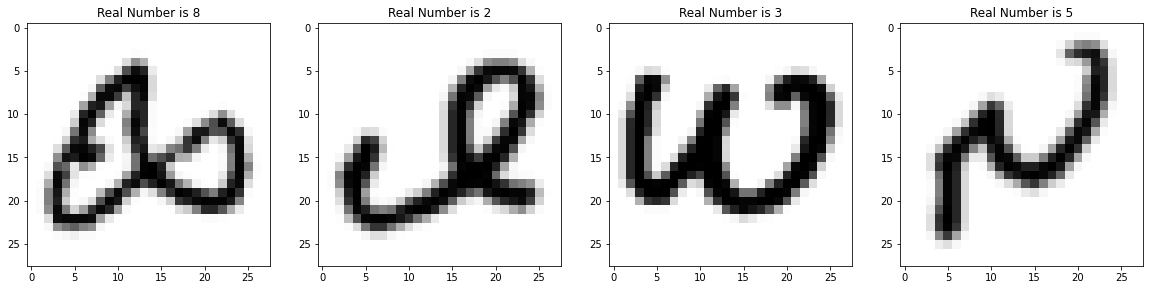

In [133]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

**Normalization**

In [134]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

# 3. CNN
## 3.1 Define the model

**Model Definition**

In [135]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [136]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 128)        

## 3.2 Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

In [137]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

For the data augmentation, i chose to :
   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height
   
**I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.**



## 3.3 Model training

### Drive training phase
**EarlyStoping**: Stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving.

In [138]:
epochs = 100
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = tensorflow.keras.callbacks.EarlyStopping(
        monitor="val_loss", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [139]:
# Fit the model
history = model.fit(train_gen, 
                  epochs = epochs, 
                  steps_per_epoch = train_steps,
                  validation_data = test_gen,
                  validation_steps = valid_steps, 
                  callbacks=[es, rp])

Epoch 1/100
1687/1687 [==============================] - 859s 509ms/step - loss: 0.1315 - accuracy: 0.9591 - val_loss: 0.0441 - val_accuracy: 0.9878
Epoch 2/100
1687/1687 [==============================] - 1044s 619ms/step - loss: 0.0352 - accuracy: 0.9898 - val_loss: 0.0405 - val_accuracy: 0.9890
Epoch 3/100
1687/1687 [==============================] - 1134s 672ms/step - loss: 0.0277 - accuracy: 0.9919 - val_loss: 0.0289 - val_accuracy: 0.9930
Epoch 4/100
1687/1687 [==============================] - 1131s 670ms/step - loss: 0.0238 - accuracy: 0.9933 - val_loss: 0.0235 - val_accuracy: 0.9941

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
1687/1687 [==============================] - 1383s 820ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.0167 - val_accuracy: 0.9958
Epoch 6/100
1687/1687 [==============================] - 1343s 796ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.0154 - val_accuracy: 0.9965
Epoch 7/100
1687/16

# 4. Evaluate the model
## 4.1 Training and validation curves

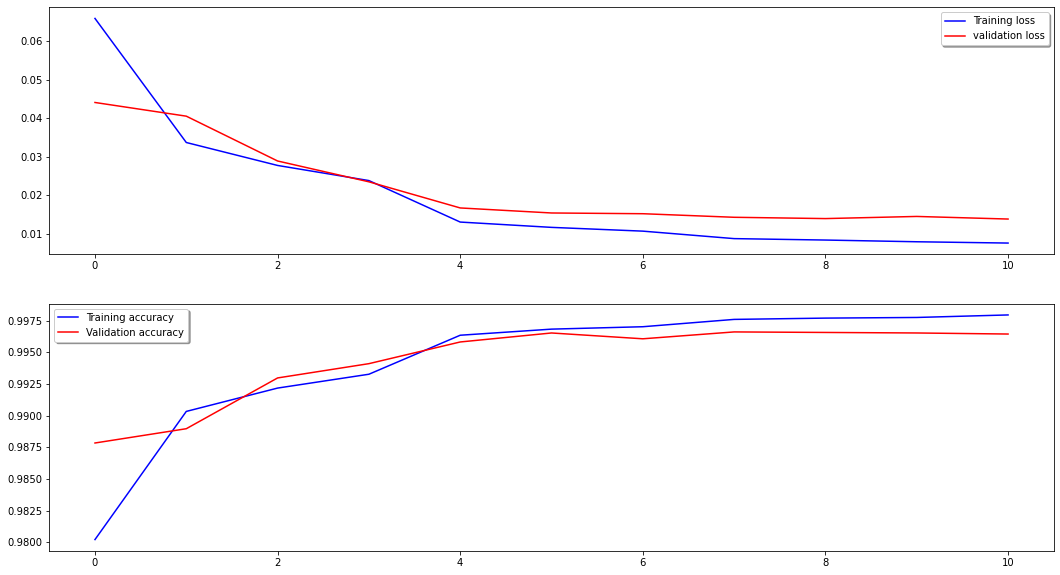

In [148]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

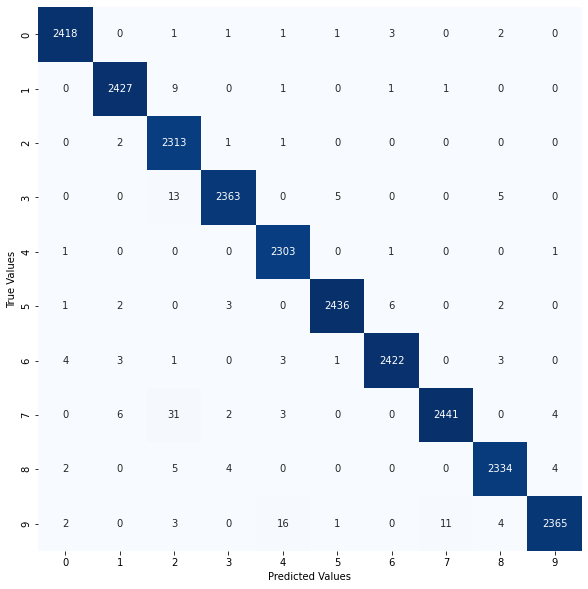

In [149]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

# 5. Prediction and submition

## 5.1 Prediction validation results

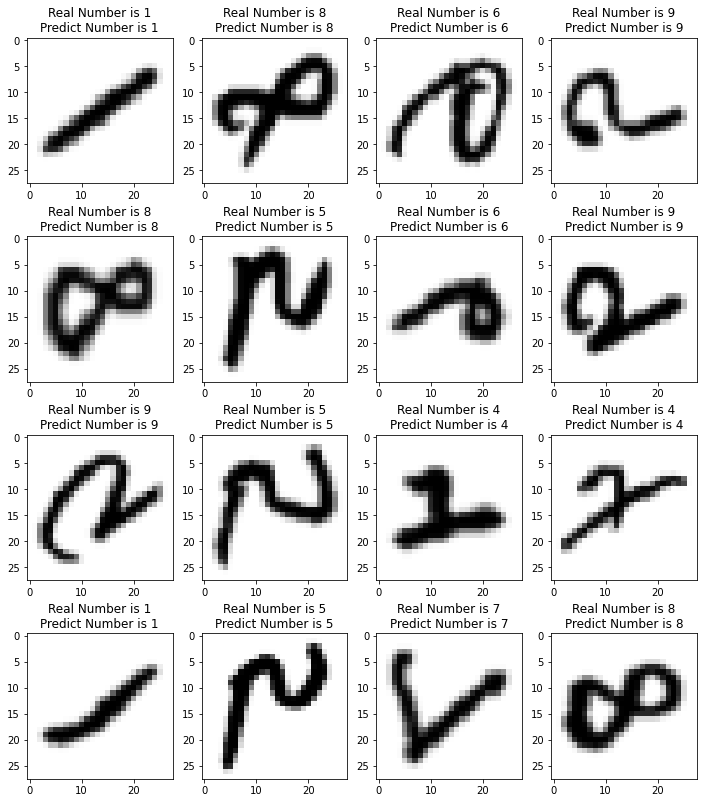

In [150]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

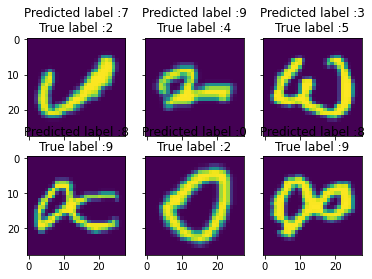

In [156]:
# Display some error results 

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

## 5.2 Submission

**Predicting test classes**

In [192]:
test_x = test
test_x = test_x / 255.0
test_x = test_x.reshape(-1,28,28,1)
# predict test data
pred = model.predict(test_x)
results = np.argmax(pred,axis = 1)

results = pd.Series(results,name="Label")

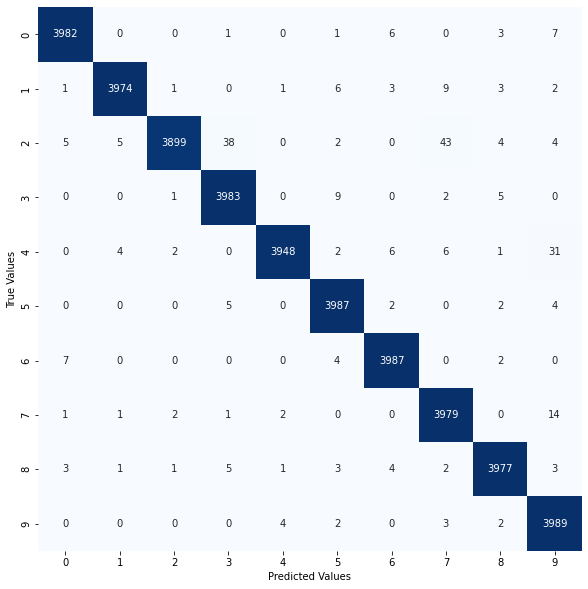

              precision    recall  f1-score   support

           0     0.9955    0.9957    0.9956      3999
           1     0.9935    0.9972    0.9954      3985
           2     0.9748    0.9982    0.9863      3906
           3     0.9958    0.9876    0.9917      4033
           4     0.9870    0.9980    0.9925      3956
           5     0.9968    0.9928    0.9948      4016
           6     0.9968    0.9948    0.9958      4008
           7     0.9948    0.9839    0.9893      4044
           8     0.9942    0.9945    0.9944      3999
           9     0.9972    0.9840    0.9906      4054

    accuracy                         0.9926     40000
   macro avg     0.9926    0.9927    0.9926     40000
weighted avg     0.9927    0.9926    0.9926     40000



In [193]:
from sklearn import metrics
fig = plt.figure(figsize=(10, 10)) # Set Figure

fin_pred = np.argmax(pred, 1) # Decode Predicted labels
# fin_pred_true_label = np.argmax(test_lbae, 1) # Decode labels

# mat = confusion_matrix(fin_pred, test_label) # Confusion matrix
mat = pd.crosstab(fin_pred, test_label)
# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

tab = pd.crosstab(fin_pred, test_label)
print(metrics.classification_report(fin_pred,test_label, digits=4))


In [191]:
submission = pd.concat([pd.Series(test_label,name = "True Label"),pd.Series(fin_pred,name = "Predicted Label")],axis = 1)

submission.to_csv("Andrew_HW6_results.csv",index=False)

# Accuracy I achieved is avg 0.9926.